In [359]:
import pandas as pd
import re


In [408]:
df = pd.read_csv("../data/synthetic_right.csv")
df_baseline = pd.read_csv("../data/synthetic_baseline_right.csv")
df_adaptive = pd.read_csv("../data/synthetic_adaptive_right.csv")

In [409]:
df_adaptive.describe()

,Unnamed: 0,elapsed,refined_dice3d_adaptive,refined_TP_adaptive,refined_FP_adaptive,refined_FN_adaptive,refined_TN_adaptive,refined_chamfer_adaptive,backproj_dice3d_adaptive,backproj_TP_adaptive,backproj_FP_adaptive,backproj_FN_adaptive,backproj_TN_adaptive,backproj_chamfer_adaptive,interpret_frac
count,153.0,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000
mean,0.0,3.928404,0.309766,197.647059,565.601307,329.882353,214906.869281,3.135986,0.101827,119.705882,1753.084967,407.823529,213719.385621,5.594847,0.055809
std,0.0,0.406654,0.117253,131.230135,486.097474,202.355437,722.253297,1.784245,0.083010,121.043483,1493.341581,199.434896,1729.796729,2.205304,0.048650
min,0.0,2.885040,0.074219,19.000000,75.000000,44.000000,211771.000000,0.839340,0.000000,0.000000,124.000000,95.000000,205379.000000,1.733911,0.008889
25%,0.0,3.637654,0.222757,92.000000,317.000000,208.000000,214792.000000,2.037897,0.041086,36.000000,804.000000,299.000000,213346.000000,4.049075,0.028519
50%,0.0,4.014328,0.319527,163.000000,447.000000,263.000000,215045.000000,2.602430,0.085865,85.000000,1339.000000,364.000000,214130.000000,5.298279,0.044811
75%,0.0,4.230330,0.396004,267.000000,616.000000,366.000000,215283.000000,3.621740,0.137547,163.000000,2180.000000,483.000000,214783.000000,6.921241,0.067130
max,0.0,4.683975,0.537600,639.000000,2806.000000,970.000000,215732.000000,11.923015,0.355212,652.000000,9198.000000,1166.000000,215651.000000,11.727833,0.278704


In [411]:
def roc_random_guess():
    import matplotlib.pyplot as plt
    plt.plot([0, 1], [0, 1], 'k--', label="Random guess")


def roc(df, prefix):
    import matplotlib.pyplot as plt
    from sklearn.metrics import auc
    
    pattern = re.compile(rf"refined_TP_(.*)")
    thresholds = []

    for col in df.columns:
        match = pattern.match(col)
        if match:
            thresholds.append(match.group(1))
            
    fpr_list, tpr_list = [], []
    for t in thresholds:
        TP = df[f"{prefix}_TP_{t}"].sum()
        TN = df[f"{prefix}_TN_{t}"].sum()
        FP = df[f"{prefix}_FP_{t}"].sum()
        FN = df[f"{prefix}_FN_{t}"].sum()

        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0.0

        tpr_list.append(TPR)
        fpr_list.append(FPR)
    
    tpr_list.append(1)
    fpr_list.append(1)
    
    fpr_list, tpr_list = zip(*sorted(zip(fpr_list, tpr_list)))
    roc_auc = auc(fpr_list, tpr_list)
    
    plt.plot(fpr_list, tpr_list, marker='o', label=f"ROC curve for {prefix} (AUC = {roc_auc:.3f})")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(f"ROC Curve ({prefix})")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()

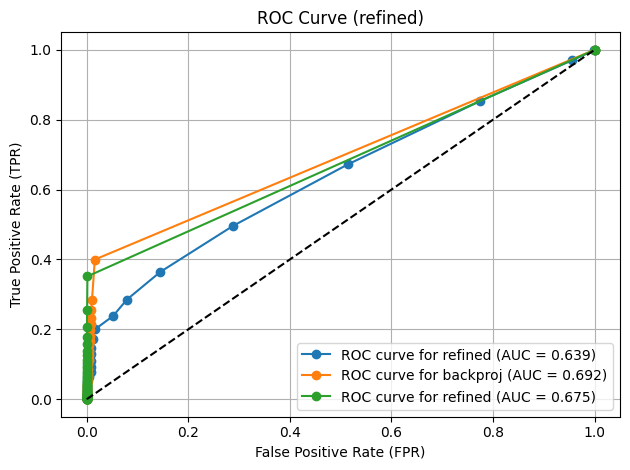

In [392]:
roc(df, prefix="refined")
roc(df, prefix="backproj")
roc(df_baseline, prefix="refined")
roc_random_guess()

In [412]:
def chamfer(df, prefix, legend, threshold_bnds=(0, 1)):
    import matplotlib.pyplot as plt
    
    pattern = re.compile(r"refined_chamfer_(.*)")
    thresholds = []

    for col in df.columns:
        match = pattern.match(col)
        if match:
            thresholds.append(match.group(1))
        
    cd_t = []    
    t = []
    for th in thresholds:
        if float(th) < threshold_bnds[0] or float(th) > threshold_bnds[1]: continue
        cd = df[f"{prefix}_chamfer_{th}"].mean()
        cd_t.append(cd)
        t.append(float(th))
     
     
    plt.plot(t, cd_t, label=legend)
    plt.yscale('log')
    plt.xlabel("Threshold (t)")
    plt.ylabel("Chamfer Distance (Cd(t))")
    plt.title(f"Chamfer Distance")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()

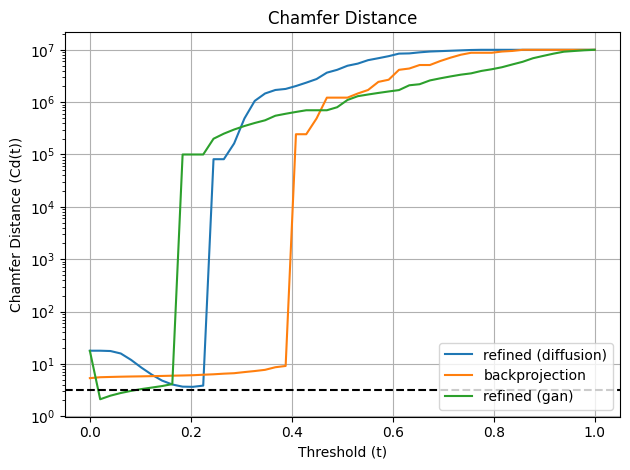

In [413]:
chamfer(df, prefix="refined", legend="refined (diffusion)")
chamfer(df, prefix="backproj", legend="backprojection")
chamfer(df_baseline, prefix="refined", legend="refined (gan)")

mean_val = df_adaptive["refined_chamfer_adaptive"].mean()
import matplotlib.pyplot as plt
plt.axhline(
    y=mean_val,
    color="black",      # choose a color
    linestyle="--",     # dashed line for clarity
    linewidth=1.5,
    label=f"adaptive mean ({mean_val:.2f})"
)



In [414]:
def metric_difference(df, metric_name, log=False, inverted=False):
    pattern = re.compile(r"refined_dice3d_(.*)")
    thresholds = []

    for col in df.columns:
        match = pattern.match(col)
        if match:
            thresholds.append(match.group(1))
        
    d3d_t = []    
    t = []
    for th in thresholds:
        d3d = df[f"refined_{metric_name}_{th}"].mean()
        d3d_bp = df[f"backproj_{metric_name}_{th}"].mean()
        t.append(float(th))
        if inverted: d3d_t.append(d3d_bp - d3d)
        else: d3d_t.append(d3d - d3d_bp)

    import matplotlib.pyplot as plt

    plt.plot(t, d3d_t)
    if inverted:
        plt.title(f"{metric_name} difference (backproj - refined)")
    else:
        plt.title(f"{metric_name} difference (refined - backproj)")
    plt.ylabel("difference")
    plt.xlabel("Threshold (t)")
    if log: plt.yscale("log")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()

/tmp/ipykernel_30162/2638060919.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


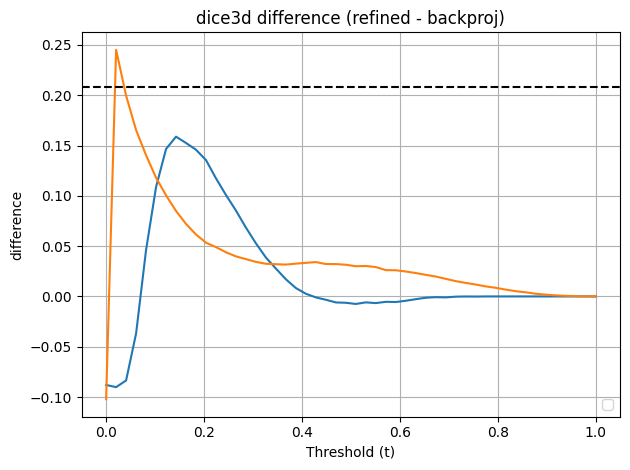

In [415]:
metric_difference(df, "dice3d")
metric_difference(df_baseline, "dice3d")

mean_val = (df_adaptive["refined_dice3d_adaptive"] - df_adaptive["backproj_dice3d_adaptive"]).mean()
plt.axhline(
    y=mean_val,
    color="black",      # choose a color
    linestyle="--",     # dashed line for clarity
    linewidth=1.5,
)

/tmp/ipykernel_30162/2638060919.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


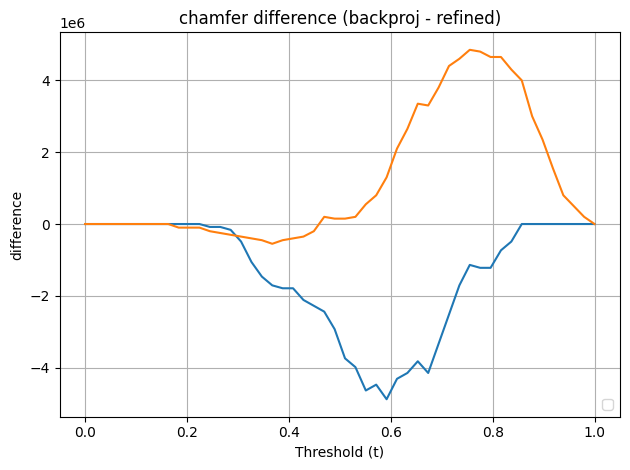

In [416]:
metric_difference(df, "chamfer", log=False, inverted=True)
metric_difference(df_baseline, "chamfer", log=False, inverted=True)

In [418]:
print(
    df["interpret_frac"].mean(),
    df_baseline["interpret_frac"].mean(),
    df_adaptive["interpret_frac"].mean(),
)

0.3585041946990509 0.47051030627192075 0.05580924882535222
